# Trend Following Box Rate

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

from DataCollect import BoxSpreadData
from SignalGenerator import SignalGenerator

## Box Rate

### Get Data

In [2]:
def get_data() -> pd.DataFrame:
    
    df_fut = BoxSpreadData().get_tsy_fut()

    df_signal = (SignalGenerator().get_trend().query(
        "data_source == 'box'").
        drop(columns = ["data_source"]))
    
    return df_fut, df_signal

df_fut, df_signal = get_data()

### Signal Analysis

First start with the correlation matrix of all of the signals across each other

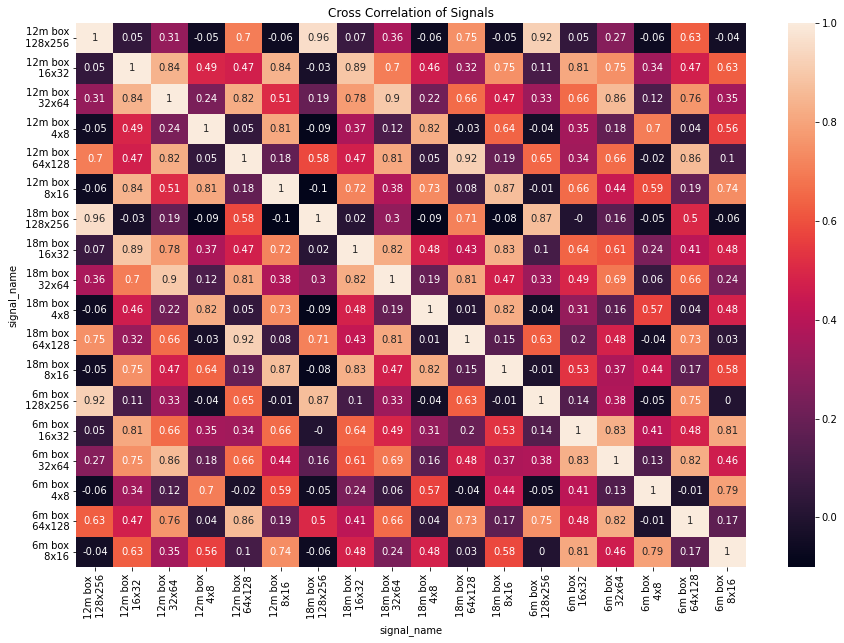

In [3]:
def plot_correlation(df_signal: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (15,10))

    df_corr = (df_signal.sort_values(
        ["short_window", "long_window"]).
        assign(signal_name = lambda x: x.group_var + "\n " + x.short_window.astype(str) + "x" + x.long_window.astype(str))
        [["date", "signal_name", "lag_signal"]].
        pivot(index = "date", columns = "signal_name", values = "lag_signal").
        tail(2_000).
        corr().
        apply(lambda x: np.round(x,2)))

    sns.heatmap(
        data  = df_corr,
        annot = True,
        ax    = axes)
    
    axes.set_title("Cross Correlation of Signals")
    
plot_correlation(df_signal)

In [4]:
def get_signal_rtn(df_fut: pd.DataFrame, df_signal: pd.DataFrame) -> pd.DataFrame:
    
    df_signal_rtn = (df_fut.merge(
        right = df_signal, how = "inner", on = ["date"]).
        drop(columns = ["group_var"]).
        assign(
            signal_name = lambda x: x.security + " " + x.variable + " " + x.short_window.astype(str) + "x" + x.long_window.astype(str),
            signal_rtn  = lambda x: -1 * np.sign(x.lag_signal) * x.PX_RTN))
    
    return df_signal_rtn

df_signal_rtn = get_signal_rtn(df_fut, df_signal)

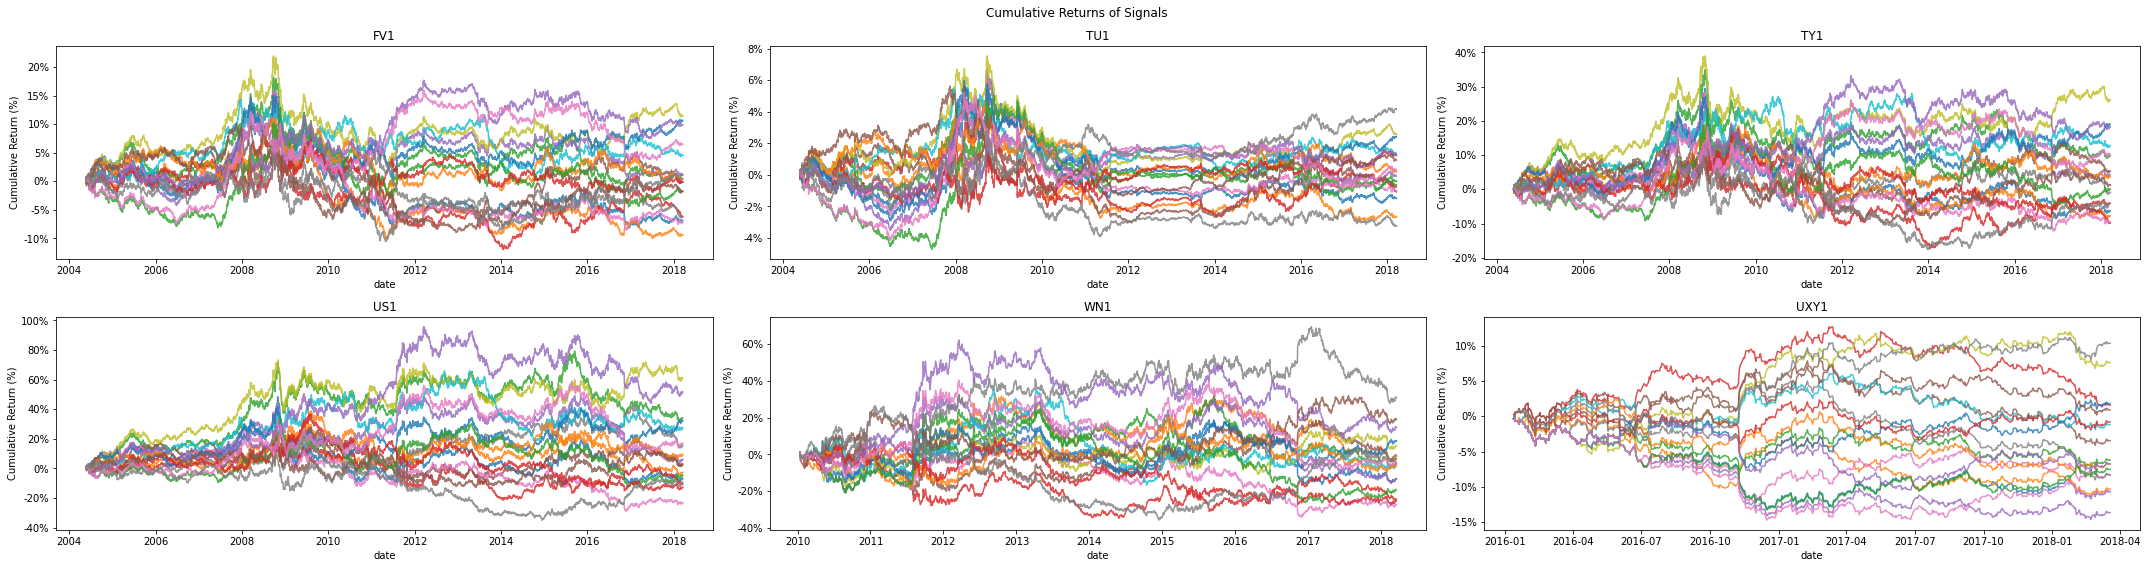

In [5]:
def plot_cumulative_returns(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    contracts = df_signal_rtn.security.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contracts) // 2, nrows = len(contracts) // 3, figsize = (30,8))

    for contract, ax in zip(contracts, axes.flatten()): 

        (df_signal_rtn.query(
            "security == @contract").
            assign(strat = lambda x: x.variable + " " + x.short_window.astype(str) + "x" + x.long_window.astype(str))
            [["strat", "date", "signal_rtn"]].
            pivot(index = "date", columns = "strat", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                legend = False,
                alpha  = 0.8,
                title  = contract,
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("Cumulative Returns of Signals")
    plt.tight_layout()
    
plot_cumulative_returns(df_signal_rtn)

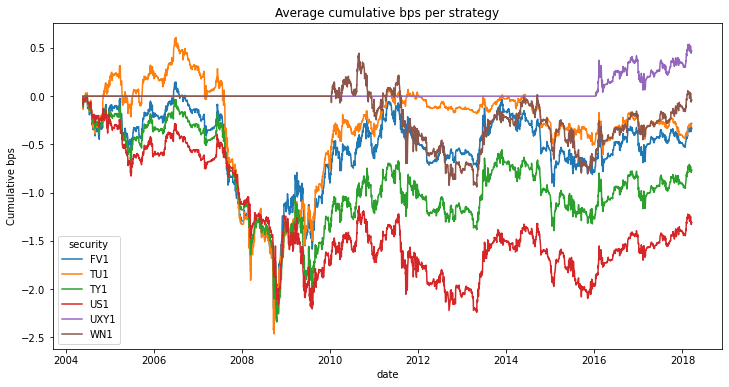

In [6]:
def plot_average_bps(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    (df_signal_rtn.assign(
        signal_bps = lambda x: x.PX_BPS * np.sign(x.lag_signal))
        [["date", "security", "signal_bps"]].
        groupby(["date", "security"]).
        agg("mean").
        reset_index().
        pivot(index = "date", columns = "security", values = "signal_bps").
        fillna(0).
        cumsum().
        plot(
            figsize = (12,6),
            title   = "Average cumulative bps per strategy",
            ylabel  = "Cumulative bps"))
    
plot_average_bps(df_signal_rtn)

In [13]:
def _get_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            signal_bps    = lambda x: x.PX_BPS * np.sign(x.lag_signal),
            signal_sharpe = lambda x: x.signal_bps.rolling(window = window).mean() / x.signal_bps.rolling(window = window).std(),
            lag_sharpe    = lambda x: x.signal_sharpe.shift()))

def get_sharpe(df_signal: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_sharpe = (df_signal_rtn.groupby(
        "signal_name").
        apply(_get_sharpe, window).
        reset_index(drop = True))
    
    return df_sharpe

df_sharpe = get_sharpe(df_signal)

In [26]:
def _get_opt_strat(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.query(
        "lag_sharpe == lag_sharpe.min() | lag_sharpe == lag_sharpe.max()").
        groupby("lag_sharpe").
        head(1).
        sort_values("lag_sharpe").
        assign(sharpe_group = ["min_sharpe", "ma_sharpe"]))
    
    return df_out

def get_opt_strat(df_sharpe: pd.DataFrame) -> pd.DataFrame:

    df_opt = (df_sharpe.dropna().groupby(
        ["security", "date"]).
        apply(_get_opt_strat).
        reset_index(drop = True))
    
    return df_opt

df_opt = get_opt_strat(df_sharpe)

<AxesSubplot:xlabel='date'>

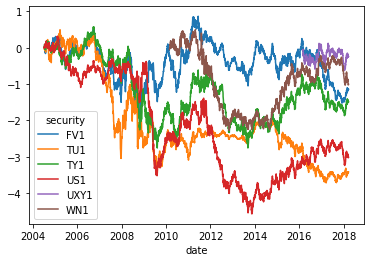

In [40]:
(df_opt.query(
    "sharpe_group == 'ma_sharpe'")
    [["date", "security", "signal_bps"]].
    pivot(index = "date", columns = "security", values = "signal_bps").
    cumsum().
    plot())